In [1]:
from cylinder_fdm_3d import CylinderFDM
from icecream import ic
import numpy as np
from scipy.sparse.linalg import eigsh, cg, gmres, bicgstab
from matplotlib import pyplot as plt
from fft_tdse.simulator import LaserPulse
from erfgau import ErfgauPotential
from rich.console import Console
from rich.table import Table
import timeit
from time import time
from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import spilu
from scipy.sparse import csc_matrix
from scipy.linalg import lu_factor, lu_solve


ic| self.m_i: array([ 0.,  1., -2., -1.])
ic| cylinder_fdm_3d.py:170 in __init__() at 13:55:02.455
ic| self.n_r: 6, self.n_z: 4, self.n_m: 4
ic| self.r_max: 20, self.z_max: 20
ic| self.n_dof: 96


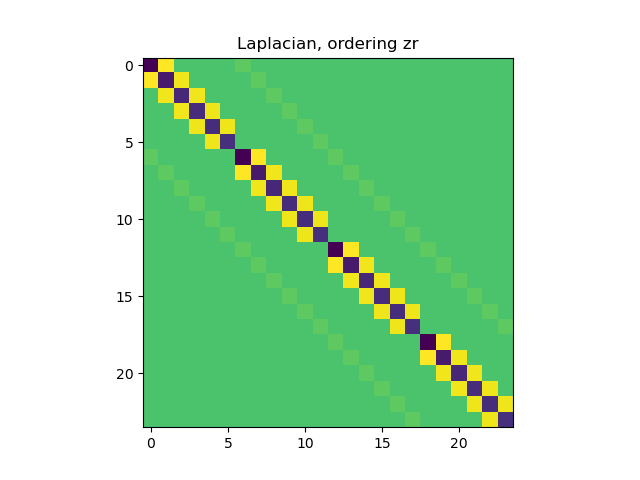

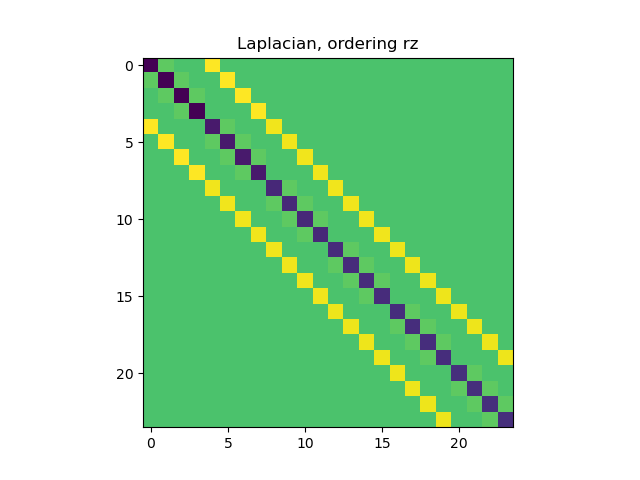

In [2]:
n_r = 6
n_z = 4
n_theta = 4
r_max = 20
z_max = 20
solver = CylinderFDM(r_max, z_max, n_r, n_z, n_theta)
L_vec_zr = solver.get_laplacian_fast(ordering='zr')
L_vec_rz = solver.get_laplacian_fast(ordering='rz')

%matplotlib widget
plt.figure()
plt.imshow(L_vec_rz[1].todense())
plt.title('Laplacian, ordering rz')
plt.figure()
plt.imshow(L_vec_zr[1].todense())
plt.title('Laplacian, ordering zr')
plt.show()



In [9]:
def solve_timing(solve, setup, n_r, n_z, m, number=10):
    # n_r = 100
    # n_z = 200
    n_theta = 2*m + 1
    r_max = 20
    z_max = 20
    fdm_solver = CylinderFDM(r_max, z_max, n_r, n_z, n_theta)
    L_vec = fdm_solver.get_laplacian_fast()
    rr, zz = fdm_solver.get_rz_meshgrid()

    u = rr**(np.abs(m) + .5) * np.exp(-(rr**2 - zz**2)/2)
    rhs = -4*np.pi*u.flatten()

    ic('system dimension = ', L_vec[0].shape[0])
    start = time()
    solve_args = setup(fdm_solver, m, rhs)
    setup_time = time() - start
    ic(setup_time)
    code = lambda: solve(*solve_args)
    time_total = timeit.timeit(code, number=number)
    time_per_solve = time_total/20
    ic(time_per_solve)
    return time_per_solve, setup_time

In [10]:

def timing_table(solve, setup, n_list, m_list):

    
    times = np.zeros((len(n_list), len(m_list)))
    setup_times = np.zeros((len(n_list), len(m_list)))
    for j,n in enumerate(n_list):
        for i,m in enumerate(m_list):
            times[j,i], setup_times[j,i] = solve_timing(solve, setup, n, n, m)

    table = Table('Timings')
    for m in m_list:
        table.add_column(f'm = {m}')
    for j,n in enumerate(n_list):
        table.add_row(f'n = {n}', *map(str,times[j]))

    display(table)
    return times, setup_times, table


In [14]:
#
# Timing of fast Poisson solver
#
def setup(fdm_solver, m, rhs):
    fdm_solver.prepare_poisson_solver()
    return fdm_solver, m, rhs

def solve(fdm_solver, m, rhs):
    return fdm_solver.solve_poisson(rhs.reshape((fdm_solver.n_r, fdm_solver.n_z)), np.abs(m))

n_list = np.array([100, 200, 400, 1000])
m_list = np.array([0, 1])
timing_table(solve, setup, n_list, m_list)
    

ic| self.m_i: array([0.])
ic| cylinder_fdm_3d.py:170 in __init__() at 14:03:52.246
ic| self.n_r: 100, self.n_z: 100, self.n_m: 1
ic| self.r_max: 20, self.z_max: 20
ic| self.n_dof: 10000
ic| 'system dimension = ', L_vec[0].shape[0]: 10000
ic| setup_time: 0.0824580192565918
ic| time_per_solve: 0.0008329978911206127
ic| self.m_i: array([ 0.,  1., -1.])
ic| cylinder_fdm_3d.py:170 in __init__() at 14:03:52.419
ic| self.n_r: 100, self.n_z: 100, self.n_m: 3
ic| self.r_max: 20, self.z_max: 20
ic| self.n_dof: 30000
ic| 'system dimension = ', L_vec[0].shape[0]: 10000
ic| setup_time: 0.011793851852416992
ic| time_per_solve: 0.00015722709940746427
ic| self.m_i: array([0.])
ic| cylinder_fdm_3d.py:170 in __init__() at 14:03:52.534
ic| self.n_r: 200, self.n_z: 200, self.n_m: 1
ic| self.r_max: 20, self.z_max: 20
ic| self.n_dof: 40000
ic| 'system dimension = ', L_vec[0].shape[0]: 40000
ic| setup_time: 0.014158964157104492
ic| time_per_solve: 0.009251304157078265
ic| self.m_i: array([ 0.,  1., -1.])
ic|

┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Timings  ┃ m = 0                 ┃ m = 1                  ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ n = 100  │ 0.0008329978911206127 │ 0.00015722709940746427 │
│ n = 200  │ 0.009251304157078265  │ 0.003758333355654031   │
│ n = 400  │ 0.003860581258777529  │ 0.0028326667030341922  │
│ n = 1000 │ 0.03470109795453027   │ 0.03136621459852904    │
└──────────┴───────────────────────┴────────────────────────┘

(array([[0.000833  , 0.00015723],
        [0.0092513 , 0.00375833],
        [0.00386058, 0.00283267],
        [0.0347011 , 0.03136621]]),
 array([[0.08245802, 0.01179385],
        [0.01415896, 0.17183995],
        [0.08563972, 0.0955348 ],
        [0.29487681, 0.59052587]]),
 <rich.table.Table at 0x29301fa90>)

In [207]:
#
# Timing of plain CG
#
setup = lambda _, A, b: {'A': A, 'b': b, 'tol': 1e-10, 'maxiter': 1000}
solve = cg
n_list = np.array([100, 200, 400])
m_list = np.array([0, 1])
timing_table(solve, setup, n_list, m_list)


ic| self.m_i: array([0.])
ic| cylinder_fdm_3d.py:169 in __init__() at 21:40:46.318
ic| self.n_r: 100, self.n_z: 100, self.n_m: 1
ic| self.r_max: 20, self.z_max: 20
ic| self.n_dof: 10000
ic| 'system dimension = ', L_vec[0].shape[0]: 10000
ic| setup_time: 5.0067901611328125e-06
ic| time_per_solve: 0.008025954151526094
ic| self.m_i: array([ 0.,  1., -1.])
ic| cylinder_fdm_3d.py:169 in __init__() at 21:40:46.542
ic| self.n_r: 100, self.n_z: 100, self.n_m: 3
ic| self.r_max: 20, self.z_max: 20
ic| self.n_dof: 30000
ic| 'system dimension = ', L_vec[0].shape[0]: 10000
ic| setup_time: 1.1920928955078125e-06
ic| time_per_solve: 0.006283968745265156
ic| self.m_i: array([0.])
ic| cylinder_fdm_3d.py:169 in __init__() at 21:40:46.710
ic| self.n_r: 200, self.n_z: 200, self.n_m: 1
ic| self.r_max: 20, self.z_max: 20
ic| self.n_dof: 40000
ic| 'system dimension = ', L_vec[0].shape[0]: 40000
ic| setup_time: 5.245208740234375e-06
ic| time_per_solve: 0.09758887080242858
ic| self.m_i: array([ 0.,  1., -1.])


┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Timings ┃ m = 0                ┃ m = 1                ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ n = 100 │ 0.008025954151526094 │ 0.006283968745265156 │
│ n = 200 │ 0.09758887080242858  │ 0.11165563125396147  │
│ n = 400 │ 0.5277262000017799   │ 0.443043818755541    │
└─────────┴──────────────────────┴──────────────────────┘

(array([[0.00802595, 0.00628397],
        [0.09758887, 0.11165563],
        [0.5277262 , 0.44304382]]),
 array([[5.00679016e-06, 1.19209290e-06],
        [5.24520874e-06, 3.81469727e-06],
        [3.81469727e-06, 7.15255737e-06]]),
 <rich.table.Table at 0x2c66a8ac0>)

In [209]:
#
# Timing of plain gmres
#
setup = lambda _, A, b: {'A': A, 'b': b, 'tol': 1e-10, 'maxiter': 1000}
solve = bicgstab
n_list = np.array([100, 200, 400])
m_list = np.array([0, 1])
timing_table(solve, setup, n_list, m_list)

ic| self.m_i: array([0.])
ic| cylinder_fdm_3d.py:169 in __init__() at 21:43:02.421
ic| self.n_r: 100, self.n_z: 100, self.n_m: 1
ic| self.r_max: 20, self.z_max: 20
ic| self.n_dof: 10000
ic| 'system dimension = ', L_vec[0].shape[0]: 10000
ic| setup_time: 4.0531158447265625e-06
ic| time_per_solve: 0.011314154148567467
ic| self.m_i: array([ 0.,  1., -1.])
ic| cylinder_fdm_3d.py:169 in __init__() at 21:43:02.710
ic| self.n_r: 100, self.n_z: 100, self.n_m: 3
ic| self.r_max: 20, self.z_max: 20
ic| self.n_dof: 30000
ic| 'system dimension = ', L_vec[0].shape[0]: 10000
ic| setup_time: 2.1457672119140625e-06
ic| time_per_solve: 0.008620060398243368
ic| self.m_i: array([0.])
ic| cylinder_fdm_3d.py:169 in __init__() at 21:43:02.928
ic| self.n_r: 200, self.n_z: 200, self.n_m: 1
ic| self.r_max: 20, self.z_max: 20
ic| self.n_dof: 40000
ic| 'system dimension = ', L_vec[0].shape[0]: 40000
ic| setup_time: 2.1457672119140625e-06
ic| time_per_solve: 0.2745467104017735
ic| self.m_i: array([ 0.,  1., -1.])


┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Timings ┃ m = 0                ┃ m = 1                ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ n = 100 │ 0.011314154148567467 │ 0.008620060398243368 │
│ n = 200 │ 0.2745467104017735   │ 0.2807751042069867   │
│ n = 400 │ 0.9695732229040004   │ 1.1364051937591284   │
└─────────┴──────────────────────┴──────────────────────┘

(array([[0.01131415, 0.00862006],
        [0.27454671, 0.2807751 ],
        [0.96957322, 1.13640519]]),
 array([[4.05311584e-06, 2.14576721e-06],
        [2.14576721e-06, 1.90734863e-06],
        [1.90734863e-06, 4.05311584e-06]]),
 <rich.table.Table at 0x2c66a9ed0>)

In [210]:
#
# Timing of  ILU-preconditioned GG
#
def setup(fdm_solver, A, b):

    LU = spilu(csc_matrix(A))
    M = LinearOperator(A.shape, LU.solve)
    return {'A': A, 'b': b, 'tol': 1e-10, 'maxiter': 1000, 'M': M}

solve = cg
n_list = np.array([100, 200, 400])
m_list = np.array([0, 1])
timing_table(solve, setup, n_list, m_list)

ic| self.m_i: array([0.])
ic| cylinder_fdm_3d.py:169 in __init__() at 21:44:45.973
ic| self.n_r: 100, self.n_z: 100, self.n_m: 1
ic| self.r_max: 20, self.z_max: 20
ic| self.n_dof: 10000
ic| 'system dimension = ', L_vec[0].shape[0]: 10000
ic| setup_time: 0.020043134689331055
ic| time_per_solve: 0.1417937207967043
ic| self.m_i: array([ 0.,  1., -1.])
ic| cylinder_fdm_3d.py:169 in __init__() at 21:44:48.880
ic| self.n_r: 100, self.n_z: 100, self.n_m: 3
ic| self.r_max: 20, self.z_max: 20
ic| self.n_dof: 30000
ic| 'system dimension = ', L_vec[0].shape[0]: 10000
ic| setup_time: 0.019572019577026367
ic| time_per_solve: 0.1410190249909647
ic| self.m_i: array([0.])
ic| cylinder_fdm_3d.py:169 in __init__() at 21:44:51.767
ic| self.n_r: 200, self.n_z: 200, self.n_m: 1
ic| self.r_max: 20, self.z_max: 20
ic| self.n_dof: 40000
ic| 'system dimension = ', L_vec[0].shape[0]: 40000
ic| setup_time: 0.09102416038513184
ic| time_per_solve: 0.9976069979020394
ic| self.m_i: array([ 0.,  1., -1.])
ic| cylinde

KeyboardInterrupt: 

In [211]:
from scipy.sparse import diags, spdiags
from scipy.sparse.linalg import splu


#
# Timing of tridiagonal-preconditioned GG
#
def setup(fdm_solver, A, b):

    data = np.array([np.append(A.diagonal(-1), 0), A.diagonal(), np.insert(A.diagonal(1), 0, 0)])
    T = spdiags(data, [-1, 0, 1], A.shape[0], A.shape[0])    # get the diagonal of the sparse matrix  A
    
    LU = splu(T)
    M = LinearOperator(A.shape, LU.solve)
    return {'A': A, 'b': b, 'tol': 1e-10, 'maxiter': 1000, 'M': M}

solve = cg
n_list = np.array([100, 200, 400])
m_list = np.array([0, 1])
timing_table(solve, setup, n_list, m_list)

ic| self.m_i: array([0.])
ic| cylinder_fdm_3d.py:169 in __init__() at 21:47:32.623
ic| self.n_r: 100, self.n_z: 100, self.n_m: 1
ic| self.r_max: 20, self.z_max: 20
ic| self.n_dof: 10000
ic| 'system dimension = ', L_vec[0].shape[0]: 10000
/Users/simenkva/anaconda3/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:395: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
ic| setup_time: 0.0048520565032958984
ic| time_per_solve: 0.022505481250118465
ic| self.m_i: array([ 0.,  1., -1.])
ic| cylinder_fdm_3d.py:169 in __init__() at 21:47:33.148
ic| self.n_r: 100, self.n_z: 100, self.n_m: 3
ic| self.r_max: 20, self.z_max: 20
ic| self.n_dof: 30000
ic| 'system dimension = ', L_vec[0].shape[0]: 10000
ic| setup_time: 0.00910186767578125
ic| time_per_solve: 0.020310118747875094
ic| self.m_i: array([0.])
ic| cylinder_fdm_3d.py:169 in __init__() at 21:47:33.625
ic| self.n_r: 200, self.n_z: 200, se

┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Timings ┃ m = 0                ┃ m = 1                ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ n = 100 │ 0.022505481250118465 │ 0.020310118747875094 │
│ n = 200 │ 0.3341591187519953   │ 0.2666449479060248   │
│ n = 400 │ 1.419138945848681    │ 1.4083655500086025   │
└─────────┴──────────────────────┴──────────────────────┘

(array([[0.02250548, 0.02031012],
        [0.33415912, 0.26664495],
        [1.41913895, 1.40836555]]),
 array([[0.00485206, 0.00910187],
        [0.01325083, 0.02670503],
        [0.05185103, 0.05710912]]),
 <rich.table.Table at 0x2c7c8cfa0>)

In [217]:
from block_lu import extract_tridiag_blocks, block_lu, block_lu_solve

def setup(fdm_solver, X, b):
    D, A, C = extract_tridiag_blocks(X, fdm_solver.n_z, fdm_solver.n_r)
    L, lu_U, C = block_lu(D, A, C)
    return {'L': L, 'lu_U': lu_U, 'C': C, 'b': b}

def solve(L, lu_U, C, b):
    return block_lu_solve(L, lu_U, C, b)


n_list = np.array([100, 200, 400, 800, 1000])
m_list = np.array([0, 1])
timing_table(solve, setup, n_list, m_list)


ic| self.m_i: array([0.])
ic| cylinder_fdm_3d.py:169 in __init__() at 22:04:43.012
ic| self.n_r: 100, self.n_z: 100, self.n_m: 1
ic| self.r_max: 20, self.z_max: 20
ic| self.n_dof: 10000
ic| 'system dimension = ', L_vec[0].shape[0]: 10000
ic| setup_time: 0.7746078968048096
ic| time_per_solve: 0.014169149997178465
ic| self.m_i: array([ 0.,  1., -1.])
ic| cylinder_fdm_3d.py:169 in __init__() at 22:04:44.286
ic| self.n_r: 100, self.n_z: 100, self.n_m: 3
ic| self.r_max: 20, self.z_max: 20
ic| self.n_dof: 30000
ic| 'system dimension = ', L_vec[0].shape[0]: 10000
ic| setup_time: 0.4878251552581787
ic| time_per_solve: 0.0145769500057213
ic| self.m_i: array([0.])
ic| cylinder_fdm_3d.py:169 in __init__() at 22:04:45.194
ic| self.n_r: 200, self.n_z: 200, self.n_m: 1
ic| self.r_max: 20, self.z_max: 20
ic| self.n_dof: 40000
ic| 'system dimension = ', L_vec[0].shape[0]: 40000
ic| setup_time: 1.2766859531402588
ic| time_per_solve: 0.019262914592400194
ic| self.m_i: array([ 0.,  1., -1.])
ic| cylinder

┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Timings  ┃ m = 0                ┃ m = 1                ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ n = 100  │ 0.014169149997178465 │ 0.0145769500057213   │
│ n = 200  │ 0.019262914592400194 │ 0.018405960395466537 │
│ n = 400  │ 0.051602968748193236 │ 0.04700287289451808  │
│ n = 800  │ 0.23954424584517256  │ 0.23393491039751096  │
│ n = 1000 │ 2.126472829200793    │ 1.9526557729113847   │
└──────────┴──────────────────────┴──────────────────────┘

(array([[0.01416915, 0.01457695],
        [0.01926291, 0.01840596],
        [0.05160297, 0.04700287],
        [0.23954425, 0.23393491],
        [2.12647283, 1.95265577]]),
 array([[ 0.7746079 ,  0.48782516],
        [ 1.27668595,  0.94020295],
        [ 5.00748801,  4.31163502],
        [37.47531009, 38.02315378],
        [86.98019814, 81.35245395]]),
 <rich.table.Table at 0x2b708cfd0>)

In [86]:
lu_solve(lu_U[0], rhs[:n_z])

array([5.85060858e+85, 1.48093144e+85, 3.47885231e+84, 8.12106822e+83,
       1.89470558e+83, 4.42024600e+82, 1.03120590e+82, 2.40536777e+81,
       5.59584186e+80, 1.23808854e+80])

In [173]:
from scipy.sparse.csgraph import reverse_cuthill_mckee
n_r = 100
n_z = 20
n_theta = 4
r_max = 20
z_max = 20
solver = CylinderFDM(r_max, z_max, n_r, n_z, n_theta)
L_vec = solver.get_laplacian_fast()
rr, zz = solver.get_rz_meshgrid()

u = rr**.5 * np.exp(-(rr**2 - zz**2)/2)
rhs = -4*np.pi*u.flatten()


P = reverse_cuthill_mckee(L_vec[0], symmetric_mode=True)

ic| self.m_i: array([ 0.,  1., -2., -1.])
ic| cylinder_fdm_3d.py:169 in __init__() at 21:08:53.243
ic| self.n_r: 100, self.n_z: 20, self.n_m: 4
ic| self.r_max: 20, self.z_max: 20
ic| self.n_dof: 8000


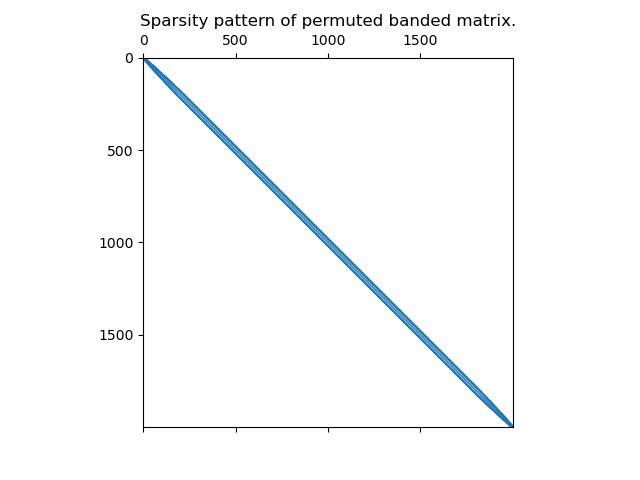

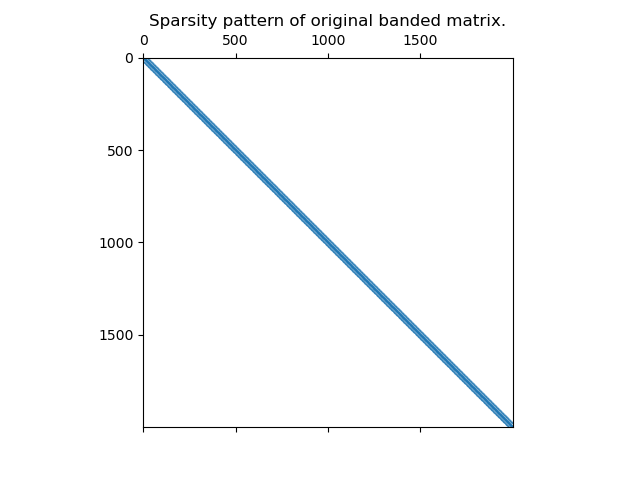

In [175]:
plt.figure()
plt.spy(L_vec[0], markersize=.1)
plt.title('Sparsity pattern of original banded matrix.')
plt.figure()
plt.spy(L_vec[0][P,:][:,P], markersize=.1)
plt.title('Sparsity pattern of permuted banded matrix.')
plt.show()

In [166]:
help(reverse_cuthill_mckee)

Help on built-in function reverse_cuthill_mckee in module scipy.sparse.csgraph._reordering:

reverse_cuthill_mckee(...)
    reverse_cuthill_mckee(graph, symmetric_mode=False)
    
    Returns the permutation array that orders a sparse CSR or CSC matrix
    in Reverse-Cuthill McKee ordering.  
    
    It is assumed by default, ``symmetric_mode=False``, that the input matrix 
    is not symmetric and works on the matrix ``A+A.T``. If you are 
    guaranteed that the matrix is symmetric in structure (values of matrix 
    elements do not matter) then set ``symmetric_mode=True``.
    
    Parameters
    ----------
    graph : sparse matrix
        Input sparse in CSC or CSR sparse matrix format.
    symmetric_mode : bool, optional
        Is input matrix guaranteed to be symmetric.
    
    Returns
    -------
    perm : ndarray
        Array of permuted row and column indices.
    
    Notes
    -----
    .. versionadded:: 0.15.0
    
    References
    ----------
    E. Cuthill and J. M

In [ ]:
from scipy.fft import dst, idst

def apply_inverse_fdm_laplacian(L, f, analytic=False):
    """ Apply the inverse of the Laplacian to a function. 
    
    The domain is [0, L] divided into len(f)+2 points, with the function
    assumed evaluated at the interior points. (Homogenous Dirichlet boundary conditions.)
    
    Args:
        L: the length of the domain
        f: the function to apply the inverse Laplacian to
        analytic: whether to use the analytic eigenvalues of the Laplacian or FDM eigenvalues
    """
    n = len(f)
    dx = L / (n+1)
    k = np.arange(1, n+1) * np.pi / L
    
    if analytic:
        evals = -k**2
    else:
        evals = (2*np.cos(k*dx) - 2)/dx**2
    return idst(evals*dst(f, type=1), type=1)



In [1]:
from cylinder_fdm_3d import CylinderFDM
from icecream import ic
import numpy as np
from scipy.sparse.linalg import eigsh, cg, gmres, bicgstab
from matplotlib import pyplot as plt
from fft_tdse.simulator import LaserPulse
from erfgau import ErfgauPotential
from rich.console import Console
from rich.table import Table
import timeit
from time import time
from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import spilu
from scipy.sparse import csc_matrix
from scipy.linalg import lu_factor, lu_solve

n_r = 6
n_z = 4
n_theta = 4
r_max = 20
z_max = 20
solver = CylinderFDM(r_max, z_max, n_r, n_z, n_theta)
L_vec_rz = solver.get_laplacian_fast(ordering='rz')
solver.prepare_poisson_solver()


ic| self.m_i: array([ 0.,  1., -2., -1.])
ic| cylinder_fdm_3d.py:170 in __init__() at 13:53:24.791
ic| self.n_r: 6, self.n_z: 4, self.n_m: 4
ic| self.r_max: 20, self.z_max: 20
ic| self.n_dof: 96


In [7]:
rr,zz = solver.get_rz_meshgrid()
m = 0
rhs = np.random.rand(n_r,n_z)
u = solver.solve_poisson(rhs, m)

In [8]:
L_vec_rz[m] @ u.flatten() - rhs.flatten()


array([-9.99200722e-16, -1.44328993e-15, -2.88657986e-15, -1.11022302e-15,
        2.22044605e-16, -1.77635684e-15, -4.10782519e-15, -1.77635684e-15,
        2.22044605e-16, -4.44089210e-16, -4.44089210e-16, -3.33066907e-16,
        3.33066907e-16, -8.88178420e-16, -6.66133815e-16, -3.33066907e-16,
        2.22044605e-16, -2.10942375e-15,  2.22044605e-16,  3.33066907e-16,
       -6.66133815e-16, -5.55111512e-17, -1.11022302e-15, -9.99200722e-16])

In [4]:
rhs.shape

(6, 4)

In [5]:
A = np.random.rand(4,5)

In [6]:

type(A @ A.T)

numpy.ndarray

In [7]:
solver.D_inverse[0]

array([[ -2.14159667,  -2.15722167,  -2.17653523,  -2.19216023],
       [ -2.52718066,  -2.54280566,  -2.56211922,  -2.57774422],
       [ -3.45136066,  -3.46698566,  -3.48629922,  -3.50192422],
       [ -5.75153057,  -5.76715557,  -5.78646914,  -5.80209414],
       [-13.29924208, -13.31486708, -13.33418064, -13.34980564],
       [-68.68046632, -68.69609132, -68.71540488, -68.73102988]])

In [6]:
solver.T_z_Lambda

array([-0.0061685 , -0.02467401, -0.05551652, -0.09869604])